In [ ]:
import os
import streamlit as st
from typing import TypedDict
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langgraph.graph import END, StateGraph
from langgraph.errors import GraphRecursionError
from langchain_core.runnables import RunnableConfig
from pydantic import BaseModel, Field, model_validator  # model_validator 임포트


# Define the GraphState class
class GraphState(TypedDict):
    question: str  # 질문
    state: str
    query: str  # 답변


# Initialize the LLM
llm = ChatOpenAI(
    temperature=0.0,
    max_tokens=300,
    model="gpt-4o-mini",
    api_key=os.environ.get("OPENAI_API_KEY")
)

class Categorized(BaseModel):
    common_conversation: bool = Field(
        description="""
            사용자가 일반적인 대화를 원하면 True, 그렇지 않으면 False를 대답해줘
        """
    )
    SQLQuery: bool = Field(
        description="""
            사용자가 쿼리문을 요청하거나, 데이터에 대한 정보를 원하면 True, 그렇지 않으면 False를 대답해줘.
        """
    )

    @model_validator(mode="after")
    def check_only_one_true(cls, values):
        if values.common_conversation == values.SQLQuery:  # 둘 다 True 또는 둘 다 False인 경우 에러 발생
            raise ValueError("common_conversation과 SQLQuery 중 하나만 True여야 합니다.")
        return values
    
# Define the check_question function to check relevance, returns True or False
def behavior_Classification(state: GraphState) -> GraphState:
    structured_llm = llm.with_structured_output(Categorized)
    structured_llm.invoke(state["question"])

    return GraphState(question=response, state=state["answer"])




# Define the llm_answer function to get an answer from the LLM
def common_answer(state: GraphState) -> GraphState:
    answer = llm.invoke(state["question"])  # Pass question as a string
    return GraphState(
        question=state["question"],
        answer=answer,
    )


def TextToSQL_answer(state: GraphState) -> GraphState:
    question = state["question"]
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a SQL expert assistant. Your task is to convert user questions into accurate SQL queries. "
                "Make sure to carefully interpret the user's intent and generate a SQL query that satisfies the requested information."
            ),
            (
                "human",
                """
                Here is the user's question:\n ------- \n{question}\n ------- \n
                Please convert this question into an SQL query that accurately represents the user's intent.
                Only provide the SQL query without any additional explanation.
                """
            ),
        ]
    )

    # Initialize the language model and generate the SQL query
    model = ChatOpenAI(
        temperature=0.0,
        max_tokens=300,
        model="gpt-4o-mini",
        api_key=os.environ.get("OPENAI_API_KEY")
    )

    chain = prompt | model | StrOutputParser()
    answer = chain.invoke({"question": question})

    return GraphState(
        question=state["question"],
        answer=answer,
    )

def beautiful_answer(state: GraphState) -> GraphState:
    answer = llm.invoke(state["question"])  # Pass question as a string
    return GraphState(
        question=state["question"],
        answer=answer,
    )


# Define the rewrite function to improve the question prompt
def rewrite_question(state):
    question = state["question"]
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are an assistant to enhance questions related to customer requirements for data analysis and advertising. "
                "The task involves improving questions based on the following customer objectives and data requirements."
            ),
            (
                "human",
                """
                Here are the key customer requirements:\n"
                "- **Channel Analysis**:\n"
                "  - Step 1: Identifying donation amount, count, and source traffic (Understand data types and relationships)\n"
                "  - Step 2: Budget planning for ads, understanding media offerings (exposure, click-through rate), and conversion to donations.\n"
                "- **Landing Page Analysis**\n"
                "- **Dataset Availability**:\n"
                "  - Planned statistics for all customer data, implementation time constraints.\n"
                "  - Risks include small sample size, possible unintended exposure.\n\n"
                "Given these, the initial question was:\n ------- \n{question}\n ------- \n"
                "Can you revise this question to better align with the customer’s analysis objectives?"
                Please be sure to answer the question, and only answer the question Korean.
                """
            ),
        ]
    )

    # Initialize the question rewriting model
    model = ChatOpenAI(
        temperature=0.0,
        max_tokens=300,
        model="gpt-4o-mini",
        api_key=os.environ.get("OPENAI_API_KEY")
    )

    chain = prompt | model | StrOutputParser()
    response = chain.invoke({"question": question})
    return GraphState(question=response, answer=state["answer"])



In [11]:
# Define the workflow
workflow = StateGraph(GraphState)

# Add nodes to the workflow
workflow.add_node("categorized", behavior_Classification)  # Add information retrieval node
workflow.add_node("common", common_answer)  # Add information retrieval node
workflow.add_node("TextToSQL", TextToSQL_answer)  # Add information retrieval node
workflow.add_node("beautiful", beautiful_answer)  # Add information retrieval node
workflow.add_node("rewrite_question", rewrite_question)  # Add question rewriting node

# Add conditional edges
workflow.add_conditional_edges(
        "categorized",
        behavior_Classification,
        {
            "True": "common",  # If relevant, end
            "False": "TextToSQL",  # If not relevant, rewrite question
            "another": "beautiful",  # If not relevant, rewrite question
        },
    )
    # Add conditional edges
workflow.add_conditional_edges(
        "TextToSQL",
        TextToSQL_answer,
        {
            "True": END,  # If relevant, end
            "False": "rewrite_question",  # If not relevant, rewrite question
        },
    )

    # Connect nodes
workflow.add_edge("rewrite_question", "TextToSQL")  # Rewrite -> Relevance Check
workflow.set_entry_point("categorized")

    # Compile the workflow
app = workflow.compile()

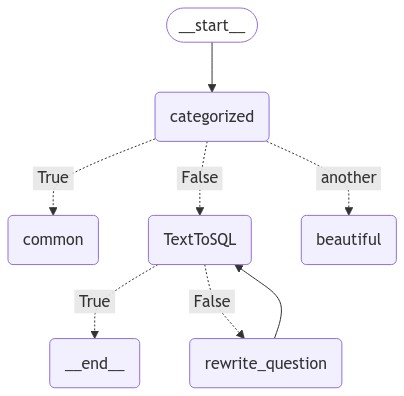

In [12]:
from IPython.display import Image, display

try:
    display(
        Image(app.get_graph(xray=True).draw_mermaid_png())
    )  # 실행 가능한 객체의 그래프를 mermaid 형식의 PNG로 그려서 표시합니다. xray=True는 추가적인 세부 정보를 포함합니다.
except:
    # 이 부분은 추가적인 의존성이 필요하며 선택적으로 실행됩니다.
    pass